In [26]:
import os
import pdfplumber
import torch
import torch.nn as nn
from torch.nn import functional as F
import matplotlib.pyplot as plt

# --------------------- Hyperparameters ---------------------
batch_size = 16      # sequences per batch
block_size = 32      # context length
max_iters = 20000
eval_interval = 100
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'  # force CPU for simplicity
eval_iters = 500
n_embd = 64
n_head = 4
n_layer = 4
dropout = 0.0
reward_interval = 50       # how often to run reward-based update
reward_coef = 1.0          # weight of RL objective in combined loss
# -----------------------------------------------------------

torch.manual_seed(1337)

# File paths
input_pdf = "datasets/alice.pdf"
qa_file     = 'datasets/alice_qa.txt'

# Step 1. Extract text from the input PDF
extracted_pages = []
with pdfplumber.open(input_pdf) as pdf:
    for page in pdf.pages:
        text = page.extract_text()
        extracted_pages.append(text)
alice_book = " ".join(extracted_pages)

# Step 2. Load Q&A pairs
def load_qa_pairs(path):
    pairs = []
    with open(path, 'r', encoding='utf-8') as f:
        content = f.read().strip().split('\n\n')
    for block in content:
        if block.startswith('Q:') and '\nA:' in block:
            q,a = block.split('\nA:')
            question = q[len('Q:'):].strip()
            answer   = a.strip()
            pairs.append((question, answer))
    return pairs

qa_pairs = load_qa_pairs(qa_file)

# Combine text and build vocabulary
with open(qa_file, 'r', encoding='utf-8') as f:
    qa_data = f.read()
text = alice_book
chars = sorted(list(set(text + qa_data)))
vocab_size = len(chars)
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s]
decode = lambda l: ''.join(itos[i] for i in l)

# Create train/val splits for supervised data
data = torch.tensor(encode(alice_book), dtype=torch.long)
n = int(0.9 * len(data))
train_data = data[:n]
test_data  = data[n:]

def get_batch(split):
    data_split = train_data if split=='train' else test_data
    ix = torch.randint(len(data_split) - block_size, (batch_size,))
    x = torch.stack([data_split[i:i+block_size] for i in ix])
    y = torch.stack([data_split[i+1:i+block_size+1] for i in ix])
    return x.to(device), y.to(device)

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ('train','val'):
        losses = torch.zeros(eval_iters, device=device)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            _, loss = model(X, Y)
            losses[k] = loss
        out[split] = losses.mean().item()
    model.train()
    return out

# --------------------- Model Definition ---------------------
class Head(nn.Module):
    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        self.dropout = nn.Dropout(dropout)
    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x)
        q = self.query(x)
        wei = q @ k.transpose(-2,-1) * (C ** -0.5)
        wei = wei.masked_fill(self.tril[:T,:T]==0, float('-inf'))
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)
        v = self.value(x)
        out = wei @ v
        return out

class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)
    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedForward(nn.Module):
    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )
    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    def __init__(self, n_embd, n_head):
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedForward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)
    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

class BigramLanguageModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.token_embedding_table    = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        # ensure seq length ≤ block_size
        idx = idx[:, -block_size:]
        B, T = idx.shape
        tok_emb = self.token_embedding_table(idx)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device))
        x = tok_emb + pos_emb
        x = self.blocks(x)
        x = self.ln_f(x)
        logits = self.lm_head(x)
        if targets is None:
            return logits, None
        B, T, V = logits.shape
        loss = F.cross_entropy(logits.view(B*T, V), targets.view(B*T))
        return logits, loss

    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -block_size:]
            logits, _ = self(idx_cond)
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat([idx, idx_next], dim=1)
        return idx

# Instantiate model and optimizer
model = BigramLanguageModel().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

# Reward function: simple exact match
from torch.distributions.categorical import Categorical

def compute_reward(gen: str, ref: str) -> float:
    return 1.0 if gen.strip() == ref.strip() else 0.0

# RL training step

def rl_update(question, reference):
    # prepare prompt
    prompt = f"Q: {question}\nA:"
    idx = torch.tensor([encode(prompt)], device=device)
    # run forward to collect logprobs
    logits_seq, _ = model(idx)
    log_probs = []
    generated = []
    # sample tokens
    for _ in range(len(encode(reference))):
        logits = logits_seq[:, -1, :]
        dist = Categorical(logits=logits)
        token = dist.sample()
        log_prob = dist.log_prob(token)
        log_probs.append(log_prob)
        generated.append(token.item())
        idx = torch.cat([idx, token.unsqueeze(0)], dim=1)
        logits_seq, _ = model(idx)
    gen_str = decode(generated)
    r = compute_reward(gen_str, reference)
    # policy gradient loss
    log_probs = torch.stack(log_probs).sum()
    loss = -reward_coef * r * log_probs
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return gen_str, r

# Create empty loss lists to track values
train_loss_values = [0.0]
test_loss_values = [0.0]
epoch_count = []

# ----------------------- Training Loop -----------------------
for iter in range(max_iters):
    # Supervised learning step
    if iter % eval_interval == 0 or iter == max_iters-1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}, delta {(losses['val']-test_loss_values[-1]):.4f} --------------------------")
        epoch_count.append(iter)
        train_loss_values.append(losses['train'])
        test_loss_values.append(losses['val'])
    xb, yb = get_batch('train')
    _, s_loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    s_loss.backward()
    optimizer.step()

    # Reinforcement update intermittently
    if iter % reward_interval == 0:
        # sample a random QA pair
        q, a = qa_pairs[torch.randint(len(qa_pairs), (1,)).item()]
        gen, rew = rl_update(q, a)
        print(f"RL iter {iter}: Q={q} | R={rew} | Gen='{gen[:50]}...'")

# Inference remains unchanged

CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, def

step 0: train loss 4.7318, val loss 4.7557, delta 4.7557 --------------------------
RL iter 0: Q=What recurring command does the Queen of Hearts shout during the trial? | R=0.0 | Gen='j™rp-ktVCuV;ONidu%Kj...'
RL iter 50: Q=What prompts Alice to follow the White Rabbit? | R=0.0 | Gen=' o ito t 8
 s ile t/Mi. t—hsDig?agouw •
e anenIme“...'
step 100: train loss 2.6536, val loss 3.0592, delta -1.6964 --------------------------
RL iter 100: Q=How does Alice’s size vary throughout the story? | R=0.0 | Gen=' hed fthetothitheg po I
Jedsus asQ Thac sos vee, b...'
RL iter 150: Q=What does Alice realize about her identity during her adventures? | R=0.0 | Gen=' le ke onicher!” Whe  retithematkth mio cheicabl, ...'
step 200: train loss 2.4889, val loss 2.9813, delta -0.0779 --------------------------
RL iter 200: Q=What nonsensical item of evidence is read during the trial? | R=0.0 | Gen='uongaf de t hanthar; Hey y wore “The)onomine juewe...'
RL iter 250: Q=How does the story conclude? | R=0.0 | Ge

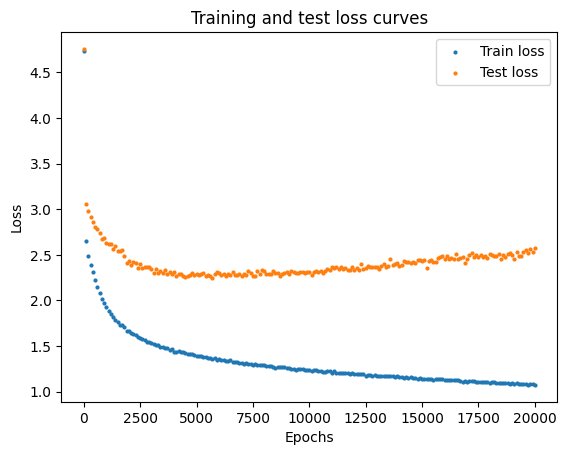

In [33]:
# Plot the loss curves
plt.scatter(epoch_count, train_loss_values[1:], label="Train loss", s=4)
plt.scatter(epoch_count, test_loss_values[1:], label="Test loss", s=4)
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

In [34]:
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "test_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

In [35]:
# 3. Save the model state dict
import os
if not os.path.exists(MODEL_SAVE_PATH):
  print(f"Saving model to: {MODEL_SAVE_PATH}")
  torch.save(obj=model.state_dict(), # only saving the state_dict() only saves the models learned parameters
            f=MODEL_SAVE_PATH)

In [36]:
# Load the model for evaluation
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Loading model from: {MODEL_SAVE_PATH}", "on device:", device)
save_model = BigramLanguageModel()
save_model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=device))
model = save_model
model.to(device)
model.eval() # Set the model to evaluation mode

Loading model from: models\test_model_1.pth on device: cuda


BigramLanguageModel(
  (token_embedding_table): Embedding(92, 64)
  (position_embedding_table): Embedding(32, 64)
  (blocks): Sequential(
    (0): Block(
      (sa): MultiHeadAttention(
        (heads): ModuleList(
          (0-3): 4 x Head(
            (key): Linear(in_features=64, out_features=16, bias=False)
            (query): Linear(in_features=64, out_features=16, bias=False)
            (value): Linear(in_features=64, out_features=16, bias=False)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (proj): Linear(in_features=64, out_features=64, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ffwd): FeedForward(
        (net): Sequential(
          (0): Linear(in_features=64, out_features=256, bias=True)
          (1): ReLU()
          (2): Linear(in_features=256, out_features=64, bias=True)
          (3): Dropout(p=0.0, inplace=False)
        )
      )
      (ln1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
   

In [37]:
def answer_question(question, max_len=100):
    prompt = f"Q: {question}\nA:"
    idx = torch.tensor([encode(prompt)], device=device)
    out = model.generate(idx, max_new_tokens=max_len)[0].tolist()
    return decode(out[len(encode(prompt)):]).strip()

In [39]:
query = "What is the first chapter of the book called?" # "What is the name of the cat in Alice's Adventures in Wonderland?"
print(f"Question: {query}")
response = answer_question(query)
print(f"Response: {response}")

Question: What is the first chapter of the book called?
Response: and the fire doors babeing in the of then in a glide.
“Well, see to caurse such a voice noticed, in


In [40]:
query = "What does Alice find on the table that she later uses to unlock a door?" # "What is the name of the cat in Alice's Adventures in Wonderland?"
print(f"Question: {query}")
response = answer_question(query)
print(f"Response: {response}")

Question: What does Alice find on the table that she later uses to unlock a door?
Response: it _was as at in a mistak its?”
“It wonver pock wee
can,” said the King,) “That it was if the dire,
